In [1]:
!pip install -q transformers datasets evaluate accelerate gluonts ujson

In [2]:
!pip install -U datasets huggingface_hub fsspec

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import lru_cache, partial
import pandas as pd
import numpy as np
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import get_lags_for_frequency
from pandas.core.arrays.period import period_array
from transformers import InformerConfig, InformerForPrediction
from transformers import PretrainedConfig
from typing import Optional

from gluonts.transform.sampler import InstanceSampler


from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from accelerate import Accelerator
from torch.optim import AdamW

from evaluate import load
from gluonts.time_feature import get_seasonality
from datetime import datetime
from tqdm import tqdm
from transformers import InformerForPrediction
from datasets import concatenate_datasets, Dataset

In [4]:
# Rocket and solver parameters
Isp = 300                # Specific impulse (s)
c_star = 1600            # Characteristic velocity (m/s)
At = 0.01                # Throat area (m^2)
g0 = 9.80665             # Gravity (m/s^2)

L_chamber = 1.0          # Chamber length (m)
N_cells = 50             # Grid cells along chamber
dx = L_chamber / N_cells
R_gas = 355              # Gas constant (J/kg·K)

time = np.linspace(0, 1, 100)  # Time vector (0–10s)
batch_size = 64                # Batch size for model inference

In [5]:
accelerator = Accelerator()
device = accelerator.device
device

device(type='cuda')

In [6]:
tc_dataset = load_dataset("shaddie/thrust_curves_dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Specify train/test split fraction
train_fraction = 0.9  # 80% for training, 20% for testing

# Split the original training set into new train/test sets
split_dataset = tc_dataset["train"].train_test_split(train_size=train_fraction, seed=42)

In [8]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 239
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 27
    })
})

In [9]:
def find_pad_max(dataset):
    l=len(dataset)
    m = 0
    for r in range(l):
        # real = tc_dataset[split][r]['feat_dynamic_real']
        target = dataset[r]['target']
        if m < len(target):
            m = len(target)

    return m


def pad_data(data, m, split):
    l=len(data)
    tc = []
    for r in range(l):
        real = data[r]['feat_dynamic_real']
        target = data[r]['target']
        rlen = len(real)
        pad = [0 for _ in range(m-rlen)]
        # target = tc_dataset['train'][r]['target']
        real = real + pad
        target = target + pad
        tc.append({
            'start': data[r]['start'],
            'target': target,
            'feat_static_cat': data[r]['feat_static_cat'],
            'feat_dynamic_real': real,
            'item_id': data[r]['item_id']
                }
            )

    return tc

In [10]:
m1 = find_pad_max(split_dataset["train"])
m2 = find_pad_max(split_dataset["test"])
m = max(m1,m2)
print(m)

61


In [11]:
train_data = pad_data(split_dataset["train"], m=m, split="train")
test_data = pad_data(split_dataset["test"], m=m, split="test")

In [12]:
# train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)
train_dataset = test_dataset

In [13]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 27
})

In [14]:
# test_dataset

In [15]:
# t_dataset = concatenate_datasets([test_dataset, test_dataset])

In [16]:
# t_dataset

In [17]:
# test_dataset = t_dataset

In [18]:
test_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 27
})

In [19]:
len(test_dataset[2]['feat_dynamic_real'])

61

In [20]:
from datetime import datetime

In [21]:
init = Dataset.from_list(
    [{
 'start': datetime(2024, 1, 25, 0, 0)
    , 'target': [0.0 for i in range(m)]
    , 'feat_static_cat': [3]
    , 'feat_dynamic_real': [0.0 for i in range(m)]
    , 'item_id': 0

},
     {
 'start': datetime(2024, 2, 25, 0, 0)
    , 'target': [0.0 for i in range(m)]
    , 'feat_static_cat': [3]
    , 'feat_dynamic_real': [0.0 for i in range(m)]
    , 'item_id': 1

},
     {
 'start': datetime(2024, 5, 10, 0, 0)
    , 'target': [0.0 for i in range(m)]
    , 'feat_static_cat': [3]
    , 'feat_dynamic_real': [0.0 for i in range(m)]
    , 'item_id': 2

}]
)


In [22]:
freq = "1W"
prediction_length = 8

# assert len(train_example["target"]) + prediction_length == len(
#     dataset["validation"][0]["target"]
# )

In [23]:
train_example = train_dataset[0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

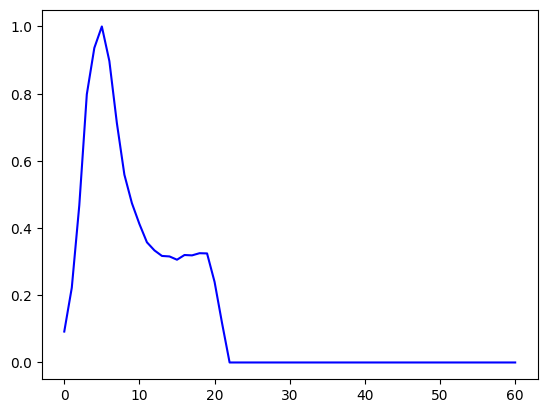

In [24]:
num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(
          # train_example["feat_dynamic_real"][-num_of_samples:],
          train_example["target"][-num_of_samples:],
          color="blue")

plt.show()

In [25]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [26]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [27]:
num_of_variates = len(test_dataset) # group according to the smaller test dataset size

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates
    # max_target_dim=num_of_variates,
    # num_test_dates=len(test_dataset),
    # num_test_dates=None, # len(test_dataset),
    # num_of_variates=num  # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [28]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (27, 95)


In [29]:
multi_variate_test_example = multi_variate_test_dataset[0]
print(
    f"multi_variate_test_example['target'].shape = {multi_variate_test_example['target'].shape}"
)

multi_variate_test_example['target'].shape = (27, 95)


In [30]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_month at 0x7ba45fb62520>, <function week_of_year at 0x7ba45fb628e0>]


Look back certain time range for each time step, as additional features "lags_sequence"

In [31]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105, 155, 156, 157]


In [32]:
timestamp = pd.Period("2025-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'day_of_month': array([-0.36666667]), 'week_of_year': array([-0.5])}


In [33]:
model = None

In [34]:
try:
    model = InformerForPrediction.from_pretrained("shaddie/rocketpill_thrustcurve_informer_model")
    print(f"successfully loaded model from hugging face with Config {model.config}")
except:
    print(f"An exception occurred when loading model from HF; initializing new model...")
    config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
    )

    model = InformerForPrediction(config)
    print(f"New model initialized with config {model.config}")

successfully loaded model from hugging face with Config InformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "InformerForPrediction"
  ],
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    0
  ],
  "context_length": 16,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 6,
  "feature_size": 111,
  "init_std": 0.02,
  "input_size": 27,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    168
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 3,
  "prediction

Note: model.config.num_static_categorical_features=0 and model.config.num_static_real_features=0
So we'll only be predicting(running inference) for the unknown value of interest (thrust), that is, the target values

If needed, set the config as shown below to allow these static values to be inferred. Pass through effects may need to be adjusted for in subsequent code

model.config.num_static_categorical_features = 1

model.config.num_static_real_features = 1

In [35]:
model.to(device)
model.config.distribution_output

'student_t'

In [36]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [37]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [38]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [39]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [40]:
config = model.config

In [41]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)


In [42]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 184, 3]) torch.FloatTensor
past_values torch.Size([256, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([256, 184, 27]) torch.FloatTensor
future_time_features torch.Size([256, 8, 3]) torch.FloatTensor
future_values torch.Size([256, 8, 27]) torch.FloatTensor
future_observed_mask torch.Size([256, 8, 27]) torch.FloatTensor


In [43]:
batch = next(iter(test_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([1, 184, 3]) torch.FloatTensor
past_values torch.Size([1, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([1, 184, 27]) torch.FloatTensor
future_time_features torch.Size([1, 8, 3]) torch.FloatTensor


In [44]:
def compute_mase_smape(forecasts):

  mase_metric = load("evaluate-metric/mase")
  smape_metric = load("evaluate-metric/smape")

  forecast_median = np.median(forecasts, 1).squeeze(0).T

  mase_metrics = []
  smape_metrics = []

  for item_id, ts in enumerate(test_dataset):
      training_data = ts["target"][:-prediction_length]
      ground_truth = ts["target"][-prediction_length:]
      mase = mase_metric.compute(
          predictions=forecast_median[item_id],
          references=np.array(ground_truth),
          training=np.array(training_data),
          periodicity=get_seasonality(freq),
      )
      mase_metrics.append(mase["mase"])

      smape = smape_metric.compute(
          predictions=forecast_median[item_id],
          references=np.array(ground_truth),
      )
      smape_metrics.append(smape["smape"])

  return np.mean(mase_metrics), np.mean(smape_metrics)

In [45]:
def run_inference():
  model.eval()
  forecasts_ = []
  test_progress_bar = tqdm(test_dataloader, desc=f"Epoch ")
  print(f'Test Eval batch data: ')
      # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
  for idx, batch in enumerate(test_progress_bar):
    for k, v in batch.items():
      print(k, v.shape, v.type())
    # print(f'past_observed_mask {batch["past_observed_mask"].to(device).repeat(1,1, 3).shape}')
    # print(f'future_time_features {batch["future_time_features"].to(device).shape}')
    outputs = model.generate(
      static_categorical_features=batch["static_categorical_features"].to(device)
      if config.num_static_categorical_features > 0
      else None,
      static_real_features=batch["static_real_features"].to(device)
      if config.num_static_real_features > 0
      else None,
      past_time_features=batch["past_time_features"].to(device),
      past_values=batch["past_values"].to(device),
      future_time_features=batch["future_time_features"].to(device),
      past_observed_mask=batch["past_observed_mask"].to(device),
    )
    term = outputs.sequences.cpu().numpy()
    print(f'term item {term[0].shape}')
    print(f'forecast_ term {term.shape}')
  forecasts_.append(outputs.sequences.cpu().numpy())
  forecasts = np.vstack(forecasts_)
  # print(f'forecasts {forecasts}')

  pred_thrust = np.clip(forecasts, 0, None)[0] # Ensure no negative values
  print(f'pred_thrust shape {pred_thrust.shape}')
  mean_samples_predicted_thrust = np.mean(pred_thrust, axis=0)

  mase, smape = compute_mase_smape(forecasts=forecasts)

  # print(f'mase: {mase} & smape: {smape}')

  return mean_samples_predicted_thrust # tbd: return the mean of the 100 (n) samples at each time step to obtain a single predicted thrust curve


In [46]:
with torch.no_grad():
  inference = run_inference()
  predicted_thrust = np.clip(inference, 0, None) # Ensure no negative values
  print(f'forecasts non-neg {predicted_thrust.shape}')

Epoch : 0it [00:00, ?it/s]

Test Eval batch data: 
past_time_features torch.Size([1, 184, 3]) torch.FloatTensor
past_values torch.Size([1, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([1, 184, 27]) torch.FloatTensor
future_time_features torch.Size([1, 8, 3]) torch.FloatTensor


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Epoch : 1it [00:00,  1.53it/s]

term item (100, 8, 27)
forecast_ term (1, 100, 8, 27)
pred_thrust shape (100, 8, 27)


forecasts non-neg (8, 27)


In [47]:
# Plot predicted thrust curves

In [48]:
# --- CALCULATIONS for LPE(LIQUID propellant engine) ---
def calc_lpe_chamber_pressure(predicted_thrust):
  v_e = Isp * g0
  mass_flow = predicted_thrust / v_e
  chamber_pressure_Pa = (mass_flow * c_star) / At
  chamber_pressure_bar = chamber_pressure_Pa / 1e5
  return chamber_pressure_bar



In [49]:
predicted_lpe_pressure = calc_lpe_chamber_pressure(predicted_thrust=predicted_thrust)
predicted_lpe_pressure.shape

(8, 27)

In [50]:
# --- CALCULATIONS for SRM (SOLID ROCKET motor) ---
def calc_srm_chamber_pressure(predicted_thrust):

  # --- CONSTANTS ---
  g0 = 9.80665                  # m/s²
  C_F = 1.5                     # Typical thrust coefficient for solid motor
  rho_prop = 1800               # Propellant density (kg/m³), e.g., for AP composite
  a = 5e-5                      # Burn rate coefficient (m/s/Paⁿ)
  n = 0.3                       # Pressure exponent (dimensionless)

  # ---Assuming a CYLINDRICAL GRAIN GEOMETRY ---
  r_inner = 0.02                # Inner port radius (m)
  r_outer = 0.05                # Outer grain radius (m)
  L_grain = 0.2                 # Grain length (m)
  A_burn = 2 * np.pi * r_inner * L_grain  # Burning surface area of port (cylindrical)

  # --- MASS FLOW RATE from THRUST ---
  # T = C_F * P_chamber * A_t  =>  P_chamber = T / (C_F * A_t)
  # Instead, use T = ṁ * v_e, and solve ṁ first:
  v_e = 2200                    # Effective exhaust velocity (m/s), typical solid SRM
  mass_flow = predicted_thrust / v_e  # (N / m/s) = kg/s

  # --- Solve for Chamber Pressure using Saint Robert's Law:
  # Rearranged: P = (ṁ / (rho * A_b * a)) ** (1/n)
  P_chamber = (mass_flow / (rho_prop * A_burn * a)) ** (1 / n)  # Pa
  P_chamber_bar = P_chamber / 1e5

  return P_chamber_bar

In [51]:
predicted_srm_pressure = calc_srm_chamber_pressure(predicted_thrust)

In [52]:
predicted_srm_pressure.shape

(8, 27)

R rows of individual thrust/pressure curves are predicted for; input the thrust/pressure row index of interest(pressure_curve_index) in pressure_time function to get it's predicted curve of length model.config.prediction_length

In [55]:
def pressure_time(predicted_pressure
                  , pressure_curve_index
                  , time_index):
  return predicted_pressure[pressure_curve_index][time_index]

In [68]:
print(f'Pressure curve 0 at time_index 5: {pressure_time(predicted_srm_pressure, 0, 5)} bar')
print(f'Pressure curve 0 at time_index 10: {pressure_time(predicted_srm_pressure, 0, 10)} bar')

Pressure curve 0 at time_index 5: 1.0114645926373456e-10 bar
Pressure curve 0 at time_index 10: 1.891132162872315e-18 bar


In [ ]:
# Plot the pressure curve